We are going to start with editing photos so they are similar for code to analyse:
- crop them
- make them grey scale
- reduce noise
- edit brightness

In [2]:
import cv2 #opencv -
import matplotlib.pyplot as plt
import numpy as np

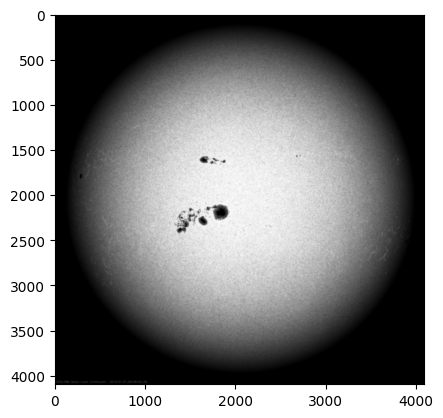

In [29]:
file_name="sdo_data/2014-01-07_0_5_25.jpg"

image_original = cv2.imread(file_name)
image = cv2.cvtColor(image_original, cv2.COLOR_RGB2GRAY)
equalized_image = cv2.equalizeHist(image)
blurred = cv2.GaussianBlur(equalized_image, (21,21), 0) 

plt.imshow(blurred, cmap='gray')
height, width = image_original.shape[:2]

First we are looking for ellipse containing the Sun

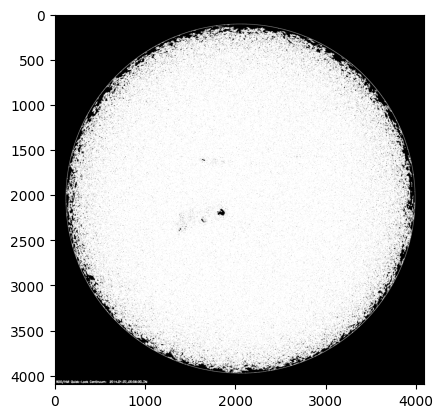

In [12]:
edges = cv2.Canny(image, 10, 50)
kernel = np.ones((3, 3), np.uint8) 
edges_dilated = cv2.dilate(edges, kernel, iterations=1)
plt.imshow(edges_dilated,cmap='gray')

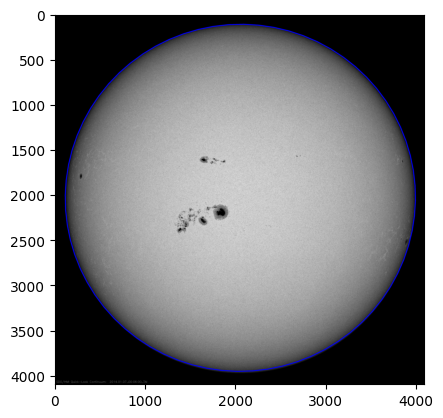

In [13]:
contours, _ = cv2.findContours(edges_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) > 0:
    elipses =[]
    areas = []
    for cnt in contours:
        if len(cnt)>=5:
            sun_ellipse = cv2.fitEllipse(cnt)
            if sun_ellipse:
                (cx, cy), (major_axis, minor_axis), angle = sun_ellipse
                sun_area=np.pi*major_axis/2*minor_axis/2
                if not (np.isnan(sun_area) or major_axis<=20 or minor_axis<=20 or major_axis/minor_axis < 0.5):
                    elipses.append(sun_ellipse)
                    areas.append(sun_area)
    max_index = np.argmax(areas)
    sun_ellipse=elipses[max_index]
    (cx, cy), (major_axis, minor_axis), angle = sun_ellipse
    image_elipse = image_original.copy()
    cv2.ellipse(image_elipse, sun_ellipse, (255, 0, 0), 10)
    plt.imshow(cv2.cvtColor(image_elipse, cv2.COLOR_BGR2RGB))
else:
    print("No contours found!")


now we are going to take inside of the sun and use dynamic threshhold on it in orderd to eliminated diffrences in lighting near the edge

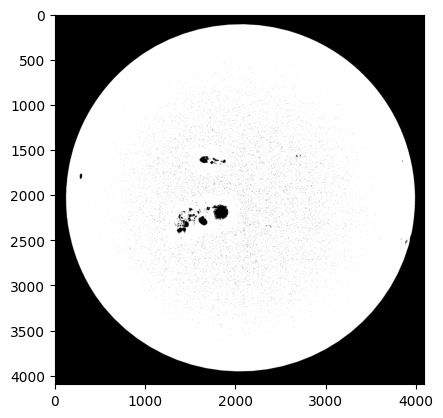

In [38]:
if sun_ellipse:
    mask = np.zeros_like(image) #black mask
    cv2.ellipse(mask, sun_ellipse, 255, -1)  #paint the elipse on mask (full inside, that's why -1)
    masked_binary = cv2.bitwise_and(image, mask)  

    new_binary=cv2.adaptiveThreshold(masked_binary,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,301,21)#THRESH_BINARY
    #_,new_binary=cv2.threshold(masked_binary,50,255,cv2.THRESH_BINARY)#THRESH_TOZERO
    new_binary =  cv2.bitwise_and(new_binary, mask)  
    plt.imshow(masked_binary, cmap='gray')
    plt.imshow(new_binary, cmap='gray')

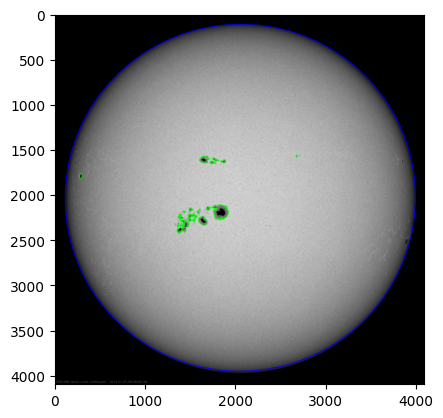

In [34]:
if sun_ellipse:  
    #caculate elipse area (in pixels^2)
    sun_area=np.pi*major_axis/2*minor_axis/2
 
    inner_contours, _ = cv2.findContours(new_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)   #Find contours inside
    min_area=sun_area/100000
    max_area = sun_area *0.99
    
    # Filtrowanie małych konturów
    filtered_contours = [cnt for cnt in inner_contours if (cv2.contourArea(cnt) > min_area and cv2.contourArea(cnt) < max_area)]
    filtered_contours.pop(0)
    
    image_contours = image_elipse.copy()
    cv2.drawContours(image_contours, filtered_contours, -1, (0, 255, 0), 5)  # Czerwone kontury

    # Wyświetlenie obrazu
    plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
    plt.show()

In [35]:
if filtered_contours:
    spots_area=0
    for contour in filtered_contours:
        spots_area+=cv2.contourArea(contour)
    print(f'Sun spots are on {spots_area/sun_area*100:.3f}% of sun area')

Sun spots are on 0.491% of sun area


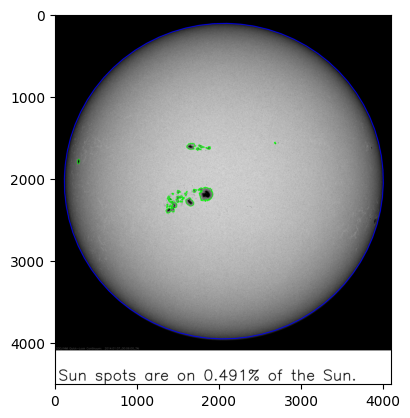

In [36]:
# Wysokość obrazu, żeby dodać tekst poniżej
height, width = image_contours.shape[:2]
# Stworzenie nowego obrazu z dodatkową przestrzenią na napis
image_with_text = cv2.copyMakeBorder(image_contours, 0, int(height/10), 0, 0, cv2.BORDER_CONSTANT, None, value = (255,255,255)) 

height, width = image_with_text.shape[:2]

# Dodanie napisu na dole
font = cv2.FONT_HERSHEY_SIMPLEX  # Czcionka
font_scale = 6
position = (int(width/100), int(height-height/100))
thickness = 10
line_type = cv2.LINE_AA
cv2.putText(image_with_text, f'Sun spots are on {spots_area/sun_area*100:.3f}% of the Sun.', position , font, font_scale, 0, thickness, line_type)

# Zapisanie obrazu z napisem
cv2.imwrite('image_with_text.jpg', image_with_text)

# Wyświetlenie obrazu
plt.imshow(cv2.cvtColor(image_with_text, cv2.COLOR_BGR2RGB))

## Below is code from above that is generating sample of 100 described images. It's optimised a little

In [57]:
import os
import random

# Path to your folder
folder_path = 'sdo_data'
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
random_files = random.sample(all_files, 100) if len(all_files) >= 100 else all_files


for file_name in random_files:
    """szukanie dysku"""
    image_original = cv2.imread(folder_path+'/'+file_name)
    image = cv2.cvtColor(image_original, cv2.COLOR_RGB2GRAY)
    height, width = image_original.shape[:2]
    edges = cv2.Canny(image, 10, 50)
    kernel = np.ones((3, 3), np.uint8) 
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    contours, _ = cv2.findContours(edges_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        elipses =[]
        areas = []
        for cnt in contours:
            if len(cnt)>=5:
                sun_ellipse = cv2.fitEllipse(cnt)
                if sun_ellipse:
                    (cx, cy), (major_axis, minor_axis), angle = sun_ellipse
                    sun_area=np.pi*major_axis/2*minor_axis/2
                    if not (np.isnan(sun_area) or major_axis<=20 or minor_axis<=20 or major_axis/minor_axis < 0.95):
                        elipses.append(sun_ellipse)
                        areas.append(sun_area)
        if len(areas)>0:
            max_index = np.argmax(areas)
            sun_ellipse=elipses[max_index]
            (cx, cy), (major_axis, minor_axis), angle = sun_ellipse
            image_elipse=cv2.ellipse(image_original, sun_ellipse, (255, 0, 0), 10)
        
            """szukanie plam"""
            if sun_ellipse:  
                    #maska
                mask = np.zeros_like(image) #black mask
                cv2.ellipse(mask, sun_ellipse, 255, -1)  #paint the elipse on mask (full inside, that's why -1)
                masked_binary = cv2.bitwise_and(image, mask)  
                new_binary=cv2.adaptiveThreshold(masked_binary,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,301,21)#THRESH_BINARY
                new_binary =  cv2.bitwise_and(new_binary, mask)  
                sun_area=np.pi*major_axis/2*minor_axis/2
                 #kontury
                inner_contours, _ = cv2.findContours(new_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)   #Find contours inside
                min_area=sun_area/100000
                max_area = sun_area *0.5
                    
                    # Filtrowanie małych konturów
                filtered_contours = [cnt for cnt in inner_contours if (cv2.contourArea(cnt) > min_area and cv2.contourArea(cnt) < max_area)]
                if len(filtered_contours) >0:
                    filtered_contours.pop(0)
                        
                    image_contours = image_elipse.copy()
                    cv2.drawContours(image_contours, filtered_contours, -1, (0, 255, 0), 5)  # Czerwone kontury
                    
                
                    spots_area=0
                    for contour in filtered_contours:
                        spots_area+=cv2.contourArea(contour)
                    print(f'Sun spots are on {spots_area/sun_area*100:.3f}% of sun area')
                    image_contours=cv2.drawContours(image_elipse, filtered_contours, -1, (0, 255, 0), 5)  # Czerwone kontury
                            
                        
                    """dodawanie napisu"""
                    image_with_text = cv2.copyMakeBorder(image_contours, 0, int(height/10), 0, 0, cv2.BORDER_CONSTANT, None, value = (255,255,255)) 
                    height, width = image_with_text.shape[:2]
                    font = cv2.FONT_HERSHEY_SIMPLEX 
                    font_scale = 6
                    position = (int(width/100), int(height-height/100))
                    thickness = 10
                    line_type = cv2.LINE_AA
                    cv2.putText(image_with_text, f'Sun spots are on {spots_area/sun_area*100:.3f}% of the Sun.', position , font, font_scale, 0, thickness, line_type)
                        
                        # Zapisanie obrazu z napisem
                    cv2.imwrite(f'sdo_sample/{file_name}_text.jpg', image_with_text)
                else:
                    print("No filtered contours!")
            else:
                print("No elipse found!")
    else:
        print("No contours found!")

Sun spots are on 0.111% of sun area
Sun spots are on 0.010% of sun area
Sun spots are on 0.271% of sun area
Sun spots are on 0.274% of sun area
No filtered contours!
Sun spots are on 0.066% of sun area
Sun spots are on 0.006% of sun area
Sun spots are on 0.206% of sun area
Sun spots are on 0.065% of sun area
Sun spots are on 0.132% of sun area
Sun spots are on 0.089% of sun area
Sun spots are on 0.004% of sun area
Sun spots are on 0.121% of sun area
No filtered contours!
No filtered contours!
Sun spots are on 0.081% of sun area
Sun spots are on 0.004% of sun area
Sun spots are on 0.006% of sun area
Sun spots are on 0.006% of sun area
No filtered contours!
Sun spots are on 0.060% of sun area
Sun spots are on 0.106% of sun area
Sun spots are on 0.023% of sun area
Sun spots are on 0.212% of sun area
Sun spots are on 0.231% of sun area
Sun spots are on 0.199% of sun area
Sun spots are on 0.191% of sun area
Sun spots are on 0.175% of sun area
Sun spots are on 0.276% of sun area
Sun spots ar